In [32]:
import sys, pathlib
import importlib
import src.features as ft
import src.external_data as ed

importlib.reload(ft)
importlib.reload(ed)

add_features = ft.add_features
load_vix = ed.load_vix

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from src.data_loading import load_eurusd
from src.features import add_features, TARGET_COL
from src.modeling import (
    train_test_split_time,
    build_logreg_pipeline,
    build_random_forest,
    build_gradient_boosting,
)
from src.evaluation import evaluate_classifier
from src.inference import predict_date_ensemble



In [33]:
from src.data_loading import load_eurusd
from src.modeling import train_test_split_time
from src.config import TARGET_COL, FEATURE_COLS

df = load_eurusd()
vix = load_vix()

df = df.merge(vix, on="date", how="left")
df["vix"] = df["vix"].ffill()

df_feat = add_features(df)

X_train, X_test, y_train, y_test = train_test_split_time(df_feat, test_size=0.2)

print(df_feat.shape)
print("Train size:", len(X_train), "| Test size:", len(X_test))
print("Target balance:")
print(df_feat[TARGET_COL].value_counts(normalize=True).round(3))

# check visuel des features enrichies
df_feat[["date"] + [c for c in FEATURE_COLS if c in df_feat.columns]].tail(5)


(14025, 20)
Train size: 11220 | Test size: 2805
Target balance:
y_up
0    0.501
1    0.499
Name: proportion, dtype: float64


,date,ret_lag1,ret_lag2,ret_lag3,ret_lag5,ret_rollmean_5,ret_rollstd_5
14026,2025-10-17,0.003822,0.003084,0.003128,0.004107,0.001001,0.003299
14027,2025-10-20,-0.001514,0.003822,0.003084,-0.003513,0.001260,0.002880
14028,2025-10-21,-0.002219,-0.001514,0.003822,0.003128,-0.000051,0.003281
14029,2025-10-22,-0.003426,-0.002219,-0.001514,0.003084,-0.000533,0.002855
14030,2025-10-23,0.000672,-0.003426,-0.002219,0.003822,-0.001590,0.001492


In [34]:
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=0,
)

xgb_model.fit(X_train, y_train)
evaluate_classifier(xgb_model, X_train, y_train, X_test, y_test, name="XGBoost (advanced)")


=== XGBoost (advanced) ===
Accuracy: 0.502
ROC-AUC : 0.496
Confusion matrix:
 [[736 664]
 [733 672]]

Classification report:
               precision    recall  f1-score   support

           0      0.501     0.526     0.513      1400
           1      0.503     0.478     0.490      1405

    accuracy                          0.502      2805
   macro avg      0.502     0.502     0.502      2805
weighted avg      0.502     0.502     0.502      2805



(0.5019607843137255, 0.49562963904422985)

In [35]:
# Version plus robuste des algos du cours (avec hyperparams un peu mieux réglés)
lr = build_logreg_pipeline()
rf = build_random_forest()
gb = build_gradient_boosting()

for m in [lr, rf, gb]:
    m.fit(X_train, y_train)

evaluate_classifier(lr, X_train, y_train, X_test, y_test, name="LogReg (advanced config)")
evaluate_classifier(rf, X_train, y_train, X_test, y_test, name="RandomForest (advanced config)")
evaluate_classifier(gb, X_train, y_train, X_test, y_test, name="GradientBoosting (advanced config)")


=== LogReg (advanced config) ===
Accuracy: 0.49
ROC-AUC : 0.483
Confusion matrix:
 [[689 711]
 [720 685]]

Classification report:
               precision    recall  f1-score   support

           0      0.489     0.492     0.491      1400
           1      0.491     0.488     0.489      1405

    accuracy                          0.490      2805
   macro avg      0.490     0.490     0.490      2805
weighted avg      0.490     0.490     0.490      2805

=== RandomForest (advanced config) ===
Accuracy: 0.487
ROC-AUC : 0.481
Confusion matrix:
 [[749 651]
 [789 616]]

Classification report:
               precision    recall  f1-score   support

           0      0.487     0.535     0.510      1400
           1      0.486     0.438     0.461      1405

    accuracy                          0.487      2805
   macro avg      0.487     0.487     0.485      2805
weighted avg      0.487     0.487     0.485      2805

=== GradientBoosting (advanced config) ===
Accuracy: 0.493
ROC-AUC : 0.486
Co

(0.493048128342246, 0.4858017285205898)

In [36]:
models = {
    "LogReg": lr,
    "RandomForest": rf,
    "GradientBoosting": gb,
    "XGBoost": xgb_model,
}

res = predict_date_ensemble(
    df_feat=df_feat,
    models=models,
    date=None,
    test_size=0.2,
    random_state=42
)

print("=== Single-date ensemble prediction (random TEST date) ===")
print("Date:", res["date"])
print("Probabilités UP par modèle:", res["model_probas_up"])
print("Moyenne P(UP):", round(res["avg_proba_up"], 3))
print("Prédiction J+1:", res["predicted_direction"])
print("Vérité terrain y_up:", res["actual_y_up"])


=== Single-date ensemble prediction (random TEST date) ===
Date: 2015-12-07 00:00:00
Probabilités UP par modèle: {'LogReg': 0.5037716775944994, 'RandomForest': 0.4912166197874318, 'GradientBoosting': 0.5174058586139798, 'XGBoost': 0.47069883346557617}
Moyenne P(UP): 0.496
Prédiction J+1: DOWN
Vérité terrain y_up: 1


In [37]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ("lr", build_logreg_pipeline()),
        ("rf", build_random_forest()),
        ("gb", build_gradient_boosting()),
        ("xgb", xgb_model),
    ],
    voting="soft",
)

ensemble.fit(X_train, y_train)
evaluate_classifier(ensemble, X_train, y_train, X_test, y_test, name="Voting ensemble (with XGB)")


=== Voting ensemble (with XGB) ===
Accuracy: 0.491
ROC-AUC : 0.487
Confusion matrix:
 [[732 668]
 [759 646]]

Classification report:
               precision    recall  f1-score   support

           0      0.491     0.523     0.506      1400
           1      0.492     0.460     0.475      1405

    accuracy                          0.491      2805
   macro avg      0.491     0.491     0.491      2805
weighted avg      0.491     0.491     0.491      2805



(0.4912655971479501, 0.48728012201321813)

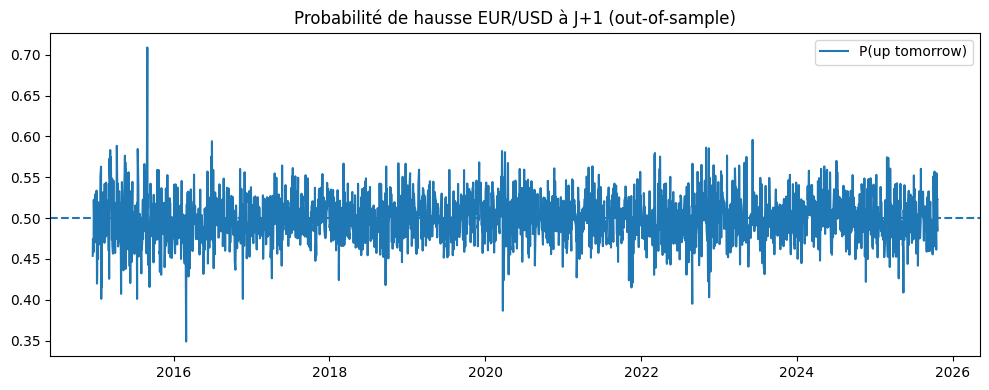

In [38]:
best_model = ensemble
proba = best_model.predict_proba(X_test)[:, 1]

cut = int(len(df_feat) * 0.8)
df_test = df_feat.iloc[cut:].copy()

plt.figure(figsize=(10, 4))
plt.plot(df_test["date"], proba, label="P(up tomorrow)")
plt.axhline(0.5, linestyle="--")
plt.title("Probabilité de hausse EUR/USD à J+1 (out-of-sample)")
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

from src.data_loading import load_eurusd
from src.external_data import load_vix
from src.features import add_features
from src.config import FEATURE_COLS

# 1) Construire un DF "affichage" avec VIX merge + ffill
df_base = load_eurusd()
vix = load_vix()

df_disp = df_base.merge(vix, on="date", how="left")
df_disp["vix"] = df_disp["vix"].ffill()

# 2) Features + dataset final
df_feat = add_features(df_disp.copy()).sort_values("date").reset_index(drop=True)

print("Période df_feat :", df_feat["date"].min().date(), "→", df_feat["date"].max().date())
print("Période VIX     :", vix["date"].min().date(), "→", vix["date"].max().date())

# 3) Définir dates
n = len(df_feat)
cut = int(n * 0.8)

all_dates = df_feat["date"].dt.strftime("%Y-%m-%d").tolist()
test_dates = df_feat.iloc[cut:]["date"].dt.strftime("%Y-%m-%d").tolist()

scope_toggle = widgets.ToggleButtons(
    options=[("Test (20% fin)", "test"), ("Toutes dates", "all")],
    value="test",
    description="Scope:"
)

date_dd = widgets.Dropdown(
    options=test_dates,
    description="Date:",
    layout=widgets.Layout(width="260px")
)

btn = widgets.Button(description="Prédire")
out = widgets.Output()

def update_dates(change=None):
    date_dd.options = test_dates if scope_toggle.value == "test" else all_dates
    if len(date_dd.options) > 0:
        date_dd.value = date_dd.options[0]

scope_toggle.observe(update_dates, names="value")


def predict_for_date(date_str):
    date = pd.to_datetime(date_str)

    row_df = df_feat[df_feat["date"] == date]
    if row_df.empty:
        raise ValueError("Date introuvable dans df_feat.")
    row = row_df.iloc[0]

    # Prix affichés
    eur_close = float(row["close"]) if "close" in row else None
    vix_val = float(row["vix"]) if "vix" in row and pd.notna(row["vix"]) else None

    # Features pour prédiction
    X_row = row[FEATURE_COLS].values.reshape(1, -1)

    probas = {name: float(m.predict_proba(X_row)[0, 1]) for name, m in models.items()}
    avg = float(sum(probas.values()) / len(probas))
    direction = "UP" if avg >= 0.5 else "DOWN"

    actual = int(row["y_up"]) if "y_up" in row else None

    return eur_close, vix_val, probas, avg, direction, actual


def run_pred(_):
    with out:
        out.clear_output()
        eur_close, vix_val, probas, avg, direction, actual = predict_for_date(date_dd.value)

        print("Date:", date_dd.value)
        print("EUR/USD close:", eur_close)
        print("VIX:", vix_val if vix_val is not None else "NA")
        print("Probabilités UP par modèle:", probas)
        print("Moyenne P(UP):", round(avg, 3))
        print("Prédiction J+1:", direction)
        print("Vérité terrain y_up:", actual)

btn.on_click(run_pred)

display(widgets.HBox([scope_toggle, date_dd, btn]))
display(out)


Période df_feat : 1971-01-12 → 2025-10-23
Période VIX     : 1990-01-02 → 2025-12-05


Output()